In [2]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import json
import os
import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
import pandas as pd
from sklearn import metrics
# import tqdm
from tqdm import tqdm
import torch
# import torch_directml
# import lightning as L

In [3]:
torch.version.cuda
print(torch.version.cuda)


None


### Feature extraction

In [4]:
file = open("config.json")
config = json.load(file)
# print(config.keys())
# print(config['data']['frame_size'])

fs = 44100              # Hz, sampling frequency
f_size = config['data']['frame_size']
h_size = config['data']['hop_size']
n_mel_channels = config['data']['n_mel_channels']

supra_frame_duration = 0.5  # seconds
supra_frame_length = round(supra_frame_duration / (h_size/fs)) # need to read from config.json / 

dir_HC = '../wav'+ os.sep + 'HC' + os.sep
dir_ALS = '../wav' + os.sep + 'ALS' + os.sep
directory_ALS = os.listdir(dir_ALS)
directory_HC = os.listdir(dir_HC)

### Pre-analysis (transform wav-file to mel-spectrogramms)

In [5]:
X = np.zeros((20000,n_mel_channels, supra_frame_length))   # data
y = np.zeros((20000,1))                     # labels
X_global_index = 0
X_ids = list([])
# Cycle for HC (helthy controls)
for i in range(len(directory_HC)):    
    if directory_HC[i][-5:]=='a.wav':
        # print(directory_HC[i][-5:])
        fileName = dir_HC + directory_HC[i]
        x, sr = librosa.load(fileName, sr=None, mono=True, offset=0.0, duration=None)

        X_melspec = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=64, n_fft=f_size, hop_length=h_size, window='hann', center=False, power=1.0)
        X_melspec = 20*np.log10(X_melspec)
            
        frame_num = X_melspec.shape[1]    

        X_melspec = X_melspec.astype(np.half)
        X_melspec.tofile(dir_HC + directory_HC[i][:-4] +'_mel.dat')

# #       #Запись фрагметов спектра в трехмерный массив 
#         N_supra_frames = frame_num - supra_frame_length + 1

#         # generator comprehension
#         gen_range = (n * 2 for n in range(0, np.floor(N_supra_frames/2).astype(int)))
#         for n in gen_range:
#             X[X_global_index,:,:] = X_melspec[:,n:n+supra_frame_length]
#             X_ids.append(int(directory_HC[i][0:3]))
#             y[X_global_index] = 0
#             X_global_index = X_global_index +1
    
# Cycle for ALS (pathology)
for i in range(len(directory_ALS)):
    if directory_ALS[i][-5:]=='a.wav':
        fileName = dir_ALS + directory_ALS[i]
        x, sr = librosa.load(fileName, sr=None, mono=True, offset=0.0, duration=None)

        X_melspec = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=64, n_fft=f_size, hop_length=h_size, window='hann', center=False, power=1.0)
        X_melspec = 20*np.log10(X_melspec)
            
        frame_num = X_melspec.shape[1]
     
        X_melspec = X_melspec.astype(np.half)
        X_melspec.tofile(dir_ALS + directory_ALS[i][:-4] +'_mel.dat')

# #       #Запись фрагметов спектра в трехмерный массив 
#         N_supra_frames = frame_num - supra_frame_length + 1

#         # generator comprehension
#         gen_range = (n * 2 for n in range(0, np.floor(N_supra_frames/2).astype(int)))
#         for n in gen_range:
#             X[X_global_index,:,:] = X_melspec[:,n:n+supra_frame_length]
#             X_ids.append(int(directory_ALS[i][0:3]))
#             y[X_global_index] = 1
#             X_global_index = X_global_index + 1


### Dataset and Dataloader

In [5]:
class ALSDataset(Dataset):
    def __init__(self, dir_HC_path, dir_ALS_path):
        """
        Аргументы:
            dir_HC_path -- путь к папке с записями здоровых голосов
            dir_ALS_path -- путь к папке с записями голосов пациентов с БАС
        """
        # self.dir_HC_path = []
        # self.dir_ALS_path = []
        self._ids = list([])    # speaker IDs
        # 5-fold CV: 13+13+13+13+12
        # ALS: 8,20,21, 22, 24, 25,27,28,31,32,39, 42,46,48,52,55,58,62,64,68,72,76,78,80,84,92,94,96,98,100,102
        # HC : 131, 129, 127, 125, 123, 121, 119, 117, 115, 113, 111, 109, 107, 99, 97, 89, 86, 85, 81, 77, 65, 63, 61, 53, 49, 42, 28, 26, 24, 16, 6, 4, 2 
        
                                                                                        # HC men+women / ALS men+women
        self.folds = list(([26,   97, 117,  85,  53,  86, 127,  92, 102,  27,  32,  72,  39], # 3+4 HC / 3+3 ALS
                           [28,  123,  63,  99,  81, 125, 129,  68,  21,  55,  48,  78,  42], # 3+4 HC / 4+2 ALS
                           [61,   16, 115, 109, 111,   2, 107,  46,  84,  64,  52,  24,  76], # 2+5 HC / 4+2 ALS
                           [77,    6,  65,  24, 131, 119,  25,  94,  62,  28,   8,  98,  22], # 3+3 HC / 5+2 ALS
                           [49,   89,   4,  42, 113, 121,  96,  20,  58,  80,  31, 100]))     # 2+4 HC / 4+2 ALS
        
        self.folds_val = list(([49, 42, 20, 31],
                              [97, 53,  92, 32],
                              [28, 99, 129, 55],  
                              [61, 111, 84, 76],  
                              [77, 24, 94, 8]))
                              
        f_size = 512            # need to read from config.json
        h_size = 256            # need to read from config.json
        n_mel_channels = 64     # need to read from config.json
        supra_frame_length = 86 # need to read from config.json
        n_input_channel = 1        
        self.X = np.zeros((20000, n_input_channel, n_mel_channels, supra_frame_length))   # data
        self.y = np.zeros((20000,1))                         # labels
        X_global_index = 0
        self.X_ids = list([])

        # Cycle for HC (helthy controls)        
        directory_HC = os.listdir(dir_HC_path)       
        for i in range(len(directory_HC)):
            if directory_HC[i][-9:]=='a_mel.dat':
                fileName = dir_HC + directory_HC[i]
            
                X_spec = np.fromfile(dir_HC + directory_HC[i], dtype=np.half)
                X_spec = np.reshape(X_spec,(n_mel_channels, np.floor(len(X_spec)/n_mel_channels).astype(int)))        

                #Запись фрагметов спектра в трехмерный массив 
                frame_num = X_spec.shape[1]
                N_supra_frames = frame_num - supra_frame_length + 1

                # generator comprehension
                gen_range = (n * 2 for n in range(0, np.floor(N_supra_frames/2).astype(int)))
                for n in gen_range:
                    self.X[X_global_index,:,:,:] = np.reshape(X_spec[:,n:n+supra_frame_length],(n_input_channel,n_mel_channels,supra_frame_length))
                    self.X_ids.append(int(directory_HC[i][0:3]))
                    self.y[X_global_index] = 0
                    X_global_index = X_global_index +1

        # Cycle for ALS (pathology)
        directory_ALS = os.listdir(dir_ALS_path)       
        for i in range(len(directory_ALS)):
            if directory_ALS[i][-9:]=='a_mel.dat':
                fileName = dir_ALS + directory_ALS[i]        

                # print(fileName)

                X_spec = np.fromfile(dir_ALS + directory_ALS[i], dtype=np.half)
                X_spec = np.reshape(X_spec,(n_mel_channels, np.floor(len(X_spec)/n_mel_channels).astype(int)))

        #       #Запись фрагметов спектра в трехмерный массив
                frame_num = X_spec.shape[1]
                N_supra_frames = frame_num - supra_frame_length + 1

                # generator comprehension
                gen_range = (n * 2 for n in range(0, np.floor(N_supra_frames/2).astype(int)))
                for n in gen_range:
                    self.X[X_global_index,:,:,:] = np.reshape(X_spec[:,n:n+supra_frame_length],(n_input_channel,n_mel_channels,supra_frame_length))
                    self.X_ids.append(int(directory_ALS[i][0:3]))
                    self.y[X_global_index] = 1
                    X_global_index = X_global_index + 1
            
        inds_to_delete = np.array(range(self.y.shape[0]))>=X_global_index
        self.y = np.delete(self.y,inds_to_delete)
        self.X = np.delete(self.X,inds_to_delete, axis=0)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        return self.X[index,:,:], self.y[index]

    def get_kth_fold_inds(self, fold_num):
        ids_train = list([])
        ids_val  = list([])
        ids_test = list([])
        for i in range(len(self.X_ids)):
            if self.X_ids[i] in self.folds[fold_num]:
                ids_test.append(i)
            elif self.X_ids[i] in self.folds_val[fold_num]:
                ids_val.append(i)
            else:
                ids_train.append(i)
        return (ids_train,ids_val, ids_test)

label =  1.0


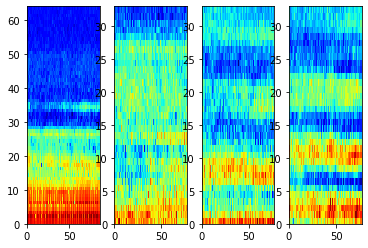

In [5]:
dir_HC = '../wav'+ os.sep + 'HC' + os.sep
dir_ALS = '../wav' + os.sep + 'ALS' + os.sep

DataSet_ALS = ALSDataset(dir_HC, dir_ALS)
# print(len(DataSet_ALS))
X_generic, y_label = DataSet_ALS.__getitem__(13202)

fig,ax = plt.subplots()
plt.subplot(141)
plt.pcolor(X_generic[0,:,:], cmap='jet')
print('label = ', y_label)
fold_0_train,fold_0_val,fold_0_test = DataSet_ALS.get_kth_fold_inds(0)

## NN
conv_lf = torch.nn.Conv2d(1,3,(32,10),padding='valid',dtype=torch.float)

input = torch.tensor(X_generic,dtype=torch.float)
output = conv_lf(input)
output_np = output.detach().numpy()
plt.subplot(142)
plt.pcolor(output_np[0,:,:], cmap='jet')
plt.subplot(143)
plt.pcolor(output_np[1,:,:], cmap='jet')
plt.subplot(144)
plt.pcolor(output_np[2,:,:], cmap='jet')

#### CNN1-model

In [49]:
class ALS_CNN1(nn.Module):
    def __init__(self):
        super(ALS_CNN1,self).__init__() 
        # parameters
        file = open("config.json")
        config = json.load(file)            
        self.n_mel = config['data']['n_mel_channels']
        frames_in_segment = config['data']['supra_frame_length']
        self.layer1_filt = 64
        
        self.lf_num = 32    # low-frequency
        self.mf_num = 16    # medium-frequency
        self.hf_num = 16    # high-frequency
        
        # low/medium/high-frequency frequency span
        # low/medium/high-frequency time span
        lf_width,lf_height = 27,27
        mf_width,mf_height = 15,15
        hf_width,hf_height = 5,5     
        hf2_width,hf2_height = 13,13

        lf_h_stride, mf_h_stride, hf_h_stride = 4,2,1
        lf_w_stride, mf_w_stride, hf_w_stride = lf_width//2, mf_width//2, hf_width//2
        
        hf2_h_stride, hf2_w_stride = 1, hf2_width//2

        self.batch_norm1 = nn.BatchNorm2d(1)
        
        # self.conv_lf = torch.nn.Conv2d(1,self.layer1_filt,(self.lf_num, lf_width),padding='valid',stride=(1,lf_width//2))
        # self.conv_mf = torch.nn.Conv2d(1,self.layer1_filt,(self.mf_num, mf_width),padding='valid',stride=(1,mf_width//2))
        # self.conv_hf = torch.nn.Conv2d(1,self.layer1_filt,(self.hf_num, hf_width),padding='valid',stride=(1,hf_width//2))

        self.conv_lf = torch.nn.Conv2d(1,self.layer1_filt,(lf_height, lf_width),padding='valid',stride=(lf_h_stride,lf_w_stride))
        self.conv_mf = torch.nn.Conv2d(1,self.layer1_filt,(mf_height, mf_width),padding='valid',stride=(mf_h_stride,mf_w_stride))
        self.conv_hf = torch.nn.Conv2d(1,self.layer1_filt,(hf_height, hf_width),padding='valid',stride=(hf_h_stride,hf_w_stride))
        self.conv_hf2 = torch.nn.Conv2d(1,self.layer1_filt,(hf2_height, hf2_width),padding='valid',stride=(hf2_h_stride,hf2_w_stride))

        self.maxpool_lf = nn.MaxPool2d(((self.lf_num - lf_height)//lf_h_stride + 1,1))
        self.maxpool_mf = nn.MaxPool2d(((self.mf_num - mf_height)//mf_h_stride + 1,1))
        self.maxpool_hf = nn.MaxPool2d(((self.hf_num - hf_height)//hf_h_stride + 1,1))
        self.maxpool_hf2 = nn.MaxPool2d(((self.hf_num - hf2_height)//hf2_h_stride + 1,1))

        self.drop1 = nn.Dropout(p=0.5)
        
        self.fc = nn.Linear(self.layer1_filt*(1+(frames_in_segment-lf_width)//lf_w_stride) + # *(1+(self.lf_num-lf_height)//lf_height)
                            self.layer1_filt*(1+(frames_in_segment-mf_width)//mf_w_stride) + #*(1+(self.mf_num-mf_height)//mf_height) + 
                            self.layer1_filt*(1+(frames_in_segment-hf_width)//hf_w_stride) +#*(1+(self.hf_num-hf_height)//hf_height)
                            self.layer1_filt*(1+(frames_in_segment-hf2_width)//hf2_w_stride)
                            ,1)    # 16 = np.round(()/5).astype(int)                                  

        torch.manual_seed(151)
        nn.init.xavier_uniform_(self.conv_lf.weight)
        nn.init.xavier_uniform_(self.conv_mf.weight)
        nn.init.xavier_uniform_(self.conv_hf.weight)
        nn.init.xavier_uniform_(self.conv_hf2.weight)
        nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x): 
        
        out = self.batch_norm1(x)

        out1 = out[:,:,:self.lf_num,:]
        out2 = out[:,:,self.lf_num:self.lf_num+self.mf_num,:]
        out3 = out[:,:,self.lf_num+self.mf_num:self.lf_num+self.mf_num+self.hf_num,:]
        
        # print(x.shape)
        # print(x1.shape)
        # for param in self.conv_lf.parameters():
        #     print(param.data)
        #     print(param.data.shape)
        # print(self.conv_lf.weight())
        # print(x2.shape)
        # print(x3.shape)
        
        out1 = self.conv_lf(out1)
        out2 = self.conv_mf(out2)
        out3 = self.conv_hf(out3)
                
        # print(out2.shape)
        # print(out3.shape)

        out1 = torch.relu(out1)
        out2 = torch.relu(out2)
        out3 = torch.relu(out3)
        
        out1 = self.maxpool_lf(out1)        
        out2 = self.maxpool_mf(out2)
        out3 = self.maxpool_hf(out3)

        out1 = out1.view(-1, out1.shape[1]*out1.shape[2]*out1.shape[3])
        out2 = out2.view(-1, out2.shape[1]*out2.shape[2]*out2.shape[3])
        out3 = out3.view(-1, out3.shape[1]*out3.shape[2]*out3.shape[3])

        # print('After view 1:', out1.shape)

        out = torch.cat((out1,out2,out3), 1)  

        # print('After cat:', out.shape)

        out = self.drop1(out)

        out = self.fc(out)
        return out    

#### CNN2-model

In [5]:
class ALS_CNN(nn.Module):
    def __init__(self):
        super(ALS_CNN,self).__init__() 
        # parameters
        file = open("drive/MyDrive/Colab Notebooks/config.json")
        config = json.load(file)            
        self.n_mel = config['data']['n_mel_channels']
        frames_in_segment = config['data']['supra_frame_length']
        layer1_filt = 18
        layer2_filt = 8
        
        self.lf_num = 32    # low-frequency
        self.mf_num = 16    # medium-frequency
        self.hf_num = 16    # high-frequency
        
        lf_width,  mf_width,  hf_width  = 48,36,16      # low/medium/high-frequency time span
        lf_height, mf_height, hf_height = 16,8,8      # low/medium/high-frequency frequency span

        l2_kernel_size = 5

        lf_h_stride, mf_h_stride, hf_h_stride = 2,1,1
        lf_w_stride, mf_w_stride, hf_w_stride = 4, 4, 4

        self.batch_norm1 = nn.BatchNorm2d(1)
        
        self.batch_norm_lf = nn.BatchNorm2d(layer1_filt)
        self.batch_norm_mf = nn.BatchNorm2d(layer1_filt)
        self.batch_norm_hf = nn.BatchNorm2d(layer1_filt)

        # self.conv_lf = torch.nn.Conv2d(1,self.layer1_filt,(self.lf_num, lf_width),padding='valid',stride=(1,lf_width//2))
        # self.conv_mf = torch.nn.Conv2d(1,self.layer1_filt,(self.mf_num, mf_width),padding='valid',stride=(1,mf_width//2))
        # self.conv_hf = torch.nn.Conv2d(1,self.layer1_filt,(self.hf_num, hf_width),padding='valid',stride=(1,hf_width//2))

        self.conv_lf = torch.nn.Conv2d(1,layer1_filt,(lf_height, lf_width),padding='valid',stride=(lf_h_stride,lf_w_stride))
        self.conv_mf = torch.nn.Conv2d(1,layer1_filt,(mf_height, mf_width),padding='valid',stride=(mf_h_stride,mf_w_stride))
        self.conv_hf = torch.nn.Conv2d(1,layer1_filt,(hf_height, hf_width),padding='valid',stride=(hf_h_stride,hf_w_stride))

        self.conv2_lf = torch.nn.Conv2d(layer1_filt, layer2_filt,l2_kernel_size,padding='valid',stride=(1,1))
        self.conv2_mf = torch.nn.Conv2d(layer1_filt, layer2_filt,l2_kernel_size,padding='valid',stride=(1,1))
        self.conv2_hf = torch.nn.Conv2d(layer1_filt, layer2_filt,l2_kernel_size,padding='valid',stride=(1,1))

        self.maxpool_lf = nn.MaxPool2d(((self.lf_num - lf_height)//lf_h_stride + 1 - (l2_kernel_size-1),1))
        self.maxpool_mf = nn.MaxPool2d(((self.mf_num - mf_height)//mf_h_stride + 1 - (l2_kernel_size-1),1))
        self.maxpool_hf = nn.MaxPool2d(((self.hf_num - hf_height)//hf_h_stride + 1 - (l2_kernel_size-1),1))

        self.drop1 = nn.Dropout(p=0.05)
        
        self.fc = nn.Linear(layer2_filt*(1+((frames_in_segment-lf_width)//lf_w_stride) - (l2_kernel_size-1)) + # *(1+(self.lf_num-lf_height)//lf_height)
                            layer2_filt*(1+((frames_in_segment-mf_width)//mf_w_stride) - (l2_kernel_size-1)) + #*(1+(self.mf_num-mf_height)//mf_height) + 
                            layer2_filt*(1+((frames_in_segment-hf_width)//hf_w_stride) - (l2_kernel_size-1)) #*(1+(self.hf_num-hf_height)//hf_height)
                            ,1)    # 16 = np.round(()/5).astype(int)                                  

        torch.manual_seed(151)
        # nn.init.xavier_uniform_(self.conv_lf.weight, gain=1.0)
        # nn.init.xavier_uniform_(self.conv_mf.weight, gain=1.0)
        # nn.init.xavier_uniform_(self.conv_hf.weight, gain=1.0)

        nn.init.kaiming_normal_(self.conv_lf.weight)
        nn.init.kaiming_normal_(self.conv_mf.weight)
        nn.init.kaiming_normal_(self.conv_hf.weight)

        nn.init.kaiming_normal_(self.conv2_lf.weight)
        nn.init.kaiming_normal_(self.conv2_mf.weight)
        nn.init.kaiming_normal_(self.conv2_hf.weight)

        nn.init.xavier_normal_(self.fc.weight)
    
    def forward(self, x): 
        
        out = self.batch_norm1(x)

        out1 = out[:,:,:self.lf_num,:]
        out2 = out[:,:,self.lf_num:self.lf_num+self.mf_num,:]
        out3 = out[:,:,self.lf_num+self.mf_num:self.lf_num+self.mf_num+self.hf_num,:]

        out1 = torch.relu(self.conv_lf(out1))
        out2 = torch.relu(self.conv_mf(out2))
        out3 = torch.relu(self.conv_hf(out3))
        
        out1 = self.batch_norm_lf(out1)
        out2 = self.batch_norm_mf(out2)
        out3 = self.batch_norm_hf(out3)

        out1 = torch.relu(self.conv2_lf(out1))
        out2 = torch.relu(self.conv2_mf(out2))
        out3 = torch.relu(self.conv2_hf(out3))

        out1 = self.maxpool_lf(out1)        
        out2 = self.maxpool_mf(out2)
        out3 = self.maxpool_hf(out3)

        out1 = out1.view(-1, out1.shape[1]*out1.shape[2]*out1.shape[3])
        out2 = out2.view(-1, out2.shape[1]*out2.shape[2]*out2.shape[3])
        out3 = out3.view(-1, out3.shape[1]*out3.shape[2]*out3.shape[3])

        # print('After view 1:', out1.shape)

        out = torch.cat((out1,out2,out3), 1)  

        # print('After cat:', out.shape)

        out = self.drop1(out)

        out = self.fc(out)
        return out

#### training_loop

In [7]:
def training_loop(n_epochs, optimizer, lr_scheduler, model, loss_fn, train_loader, val_loader):    
    MODEL_PATH = "model_backup/model_cnn.pt"
    loss_train_history = np.ndarray((n_epochs))
    loss_val_history = np.ndarray((n_epochs))
    lrs = []
    for epoch in range(1,n_epochs+1):        
        model.train()
        loss_val_best = 0
        loss_train = 0.0
        for specs, labels in tqdm(train_loader, desc=f"Epoch {epoch}", leave=True): #train_loader:
            specs = specs.float()
            outputs = model(specs)                        
            outputs = outputs.squeeze(dim=1) # for batch train_loader 
            # print('output:',outputs)
            # print('labels:',labels)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()            
        
        # prediction on val set        
        loss_val = 0.0
        TP_TN_sum = 0
        item_num = 0
        model.eval()
        with torch.no_grad():            
            for spec, label in val_loader:
                spec = spec.float()                    
                pred = model(spec)                                
                pred = torch.squeeze(pred,1)                

                loss = loss_fn(pred, label)
                loss_val += loss.item()
                
                item_num += len(label)

                pred = (pred>0)*1.0
                TP_TN_sum = TP_TN_sum + torch.sum(label==pred)

        acc_val = TP_TN_sum/item_num
        
        loss_train_history[epoch-1] = loss_train / len(train_loader)
        loss_val_history[epoch-1] = loss_val / len(val_loader)


        if loss_val > loss_val_best:
            torch.save(model.state_dict(), MODEL_PATH)            
            loss_val_best = loss_val

        # if epoch==1 or epoch%2==0:                                                            
        print(f'{datetime.datetime.now()} Epoch {epoch}, Train loss {loss_train / len(train_loader):.3f}, Val loss {loss_val / len(val_loader):.3f}, Acc_val = {acc_val:.2f}')
        
        lrs.append(optimizer.param_groups[0]["lr"])
        lr_scheduler.step()
        
    # model = torch.load(MODEL_PATH)
    model.load_state_dict(torch.load(MODEL_PATH))

    fig, ax = plt.subplots(figsize=(6,2.5))
    plt.rcParams.update({'font.size': 12})
    # plt.subplot(1,2,1)
    plt.plot(range(n_epochs), loss_train_history, label='Обучающий набор')
    plt.plot(range(n_epochs), loss_val_history, label='Проверочный набор')
    plt.legend()
    plt.xlabel('Эпоха')
    plt.ylabel('Ошибка обучения')
    # plt.subplot(1,2,2)
    # plt.plot(range(len(lrs)),lrs)
    # plt.xlabel('step')
    # plt.ylabel('lr')    
    plt.show()
    # Saving results
    # image_name = f'figures/loss_NN.jpg'
    # fig.savefig(image_name, format='jpg', dpi=110, bbox_inches='tight', pad_inches = 0.2)
    return (loss_train_history,loss_val_history)

### Single NN training & evaluation

In [48]:
# Test inference
model = ALS_CNN()
X, y = DataSet_ALS.__getitem__(13202)
input = torch.tensor(X, dtype=torch.float)
input = input.unsqueeze(0)  # add chanel dimension
input = input.unsqueeze(0)  # add batch dimension
print(input.shape)
y_out = model(input)

torch.Size([1, 1, 64, 86])


In [ ]:
fold_0_train_inds,fold_0_val_inds,fold_0_test_inds = DataSet_ALS.get_kth_fold_inds(0)
train_set = torch.utils.data.dataset.Subset(DataSet_ALS, fold_0_train_inds)
val_set = torch.utils.data.dataset.Subset(DataSet_ALS, fold_0_val_inds)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=50, shuffle=True) # num_workers=1
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1, shuffle=False) # num_workers=1

# model = ALS_FFNN()
model = ALS_CNN()
model.train()

# summary(ALS_cnn,(64*86))
# optimizer = optim.SGD(ALS_cnn.parameters(), lr=1e-3, momentum=0.10)
optimizer = optim.Adam(model.parameters(),lr=2e-5, weight_decay=2e-1)

# loss_fn = nn.CrossEntropyLoss()
# pos_weight = torch.ones([1])
# loss_fn = nn.BCEWithLogitsLoss(pos_weight = pos_weight)

loss_fn = nn.BCEWithLogitsLoss()
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

training_loop(
    n_epochs=20,
    optimizer=optimizer,
    lr_scheduler = scheduler,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader,
    val_loader = val_loader
)

### Train with 5-fold CV

#### crossvalid

In [24]:
def crossvalid(dataset=None, model = None, train = None, optimizer = None, n_epochs = 20, k_fold=5):    
    
    total_size = len(dataset)
    y_pred = np.ndarray(total_size)
    y_true = np.ndarray(total_size)
    folds = list([4,3,2,1,0])

    for i in folds: #range(k_fold):
        
        inds_train,inds_val,inds_test = dataset.get_kth_fold_inds(i)                
        
        train_set = torch.utils.data.dataset.Subset(dataset,inds_train)
        val_set = torch.utils.data.dataset.Subset(dataset,inds_val)
        test_set = torch.utils.data.dataset.Subset(dataset,inds_test)
                
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=100,shuffle=True)  # num_workers=2
        val_loader = torch.utils.data.DataLoader(val_set, batch_size=1, shuffle=False)
        test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False)    # num_workers=2
        
        torch.manual_seed(707)
        with torch.no_grad():
            for layer in model.children():
                if hasattr(layer, 'reset_parameters'):
                    # print(layer.weight())
                    layer.reset_parameters()
                    # print(layer.weight())
        
        model.train()        

        loss_fn = nn.BCEWithLogitsLoss()
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

        train(
            n_epochs=n_epochs,
            optimizer=optimizer,
            lr_scheduler = scheduler,
            model=model,
            loss_fn=loss_fn,
            train_loader=train_loader,
            val_loader=val_loader
        )

        # prediction on test set        
        test_score = list()
        TP_TN_sum = 0
        model.eval()
        with torch.no_grad():
            i = 0
            for spec, label in test_loader:
                spec = spec.float()
                # spec = spec.squeeze()
                pred = model(spec)
                pred = torch.squeeze(pred,1)  
                test_score.append(pred.numpy())
                if pred>0:
                    pred = torch.tensor(1, dtype=torch.float64)
                    y_pred[inds_test[i]] = 1
                else:
                    pred = torch.tensor(0, dtype=torch.float64)                
                    y_pred[inds_test[i]] = 0
                y_true[inds_test[i]] = label
                if pred==label:
                    TP_TN_sum +=1                
                i +=1                 
            print('Acc = ', TP_TN_sum/len(test_score))

    acc_sk = metrics.accuracy_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    prec = metrics.precision_score(y_true, y_pred)
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
    sensetivity = tp / (tp+fn)
    specificity = tn / (tn+fp)
    print('Final results')
    print(f'Acc_sk = {acc_sk:.2f}', )
    print(f'Prec = {prec:.2f}')
    print(f'Recall = {recall:.2f}')
    print(f'Sens = {sensetivity:.2f}')
    print(f'Spec = {specificity:.2f}')

        # val_acc = valid(res_model,criterion,optimizer,val_loader)
        # val_score.at[i] = val_acc
    
    return acc_sk
        
# https://stackoverflow.com/questions/60883696/k-fold-cross-validation-using-dataloaders-in-pytorch

#### k_fold_CV

In [8]:
def k_fold_CV(dataset=None, model = None, train = None, optimizer = None, n_epochs = 20, k_fold=5):    
    
    total_size = len(dataset)
    y_pred = np.ndarray(total_size)
    y_true = np.ndarray(total_size)
    folds = list([4,3,2,1,0])

    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

    PATH = 'model_backup' + os.sep + 'cnn_init.pt'
    PATH_optim = 'model_backup'+os.sep+'cnn_optim_init.pt'
    PATH_lr = 'model_backup' + os.sep + 'cnn_lr_schedule_init.pt'

    torch.save(model.state_dict(), PATH)
    torch.save(optimizer.state_dict(), PATH_optim)
    torch.save(scheduler.state_dict(), PATH_lr)

    loss_train_history_list = list()
    loss_val_history_list = list()
    fold_acc = list()
    for i in folds: #range(k_fold):
        
        inds_train,inds_val,inds_test = dataset.get_kth_fold_inds(i)                
        
        train_set = torch.utils.data.dataset.Subset(dataset,inds_train)
        val_set = torch.utils.data.dataset.Subset(dataset,inds_val)
        test_set = torch.utils.data.dataset.Subset(dataset,inds_test)
                
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=100,shuffle=True)  # num_workers=2
        val_loader = torch.utils.data.DataLoader(val_set, batch_size=100, shuffle=False)
        test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False)    # num_workers=2
        
        model.load_state_dict(torch.load(PATH))
        optimizer.load_state_dict(torch.load(PATH_optim))
        scheduler.load_state_dict(torch.load(PATH_lr))

        model.train()        

        loss_fn = nn.BCEWithLogitsLoss()        

        loss_train_history, loss_val_history = train(
            n_epochs=n_epochs,
            optimizer=optimizer,
            lr_scheduler = scheduler,
            model=model,
            loss_fn=loss_fn,
            train_loader=train_loader,
            val_loader=val_loader
        )

        loss_train_history_list.append(loss_train_history)
        loss_val_history_list.append(loss_val_history)

        # prediction on test set        
        test_score = list()
        TP_TN_sum = 0
        model.eval()
        with torch.no_grad():
            i = 0
            for spec, label in test_loader:
                spec = spec.float()
                # spec = spec.squeeze()
                pred = model(spec)
                pred = torch.squeeze(pred,1)  
                # test_score.append(pred.numpy())
                test_score.append(pred)
                if pred>0:
                    pred = torch.tensor(1, dtype=torch.float64)
                    y_pred[inds_test[i]] = 1
                else:
                    pred = torch.tensor(0, dtype=torch.float64)                
                    y_pred[inds_test[i]] = 0                    
                y_true[inds_test[i]] = label

                if pred==label:
                    TP_TN_sum +=1                
                i +=1
            fold_acc.append(TP_TN_sum/len(test_score))
            print('Acc = ', TP_TN_sum/len(test_score))

    fig, ax = plt.subplots(figsize=(12,2.5))
    plt.rcParams.update({'font.size': 10})    

    for i in folds:
        plt.subplot(1,len(folds),i+1)
        plt.plot(range(n_epochs), loss_train_history_list[i], label='Обучающий набор')
        plt.plot(range(n_epochs), loss_val_history_list[i], label='Проверочный набор')
        plt.legend()
        plt.xlabel('Эпоха')
        plt.ylabel('Ошибка обучения')
    

    acc_sk = metrics.accuracy_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    prec = metrics.precision_score(y_true, y_pred)
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
    sensetivity = tp / (tp+fn)
    specificity = tn / (tn+fp)
    
    print('Final results')
    print(f'{n_epochs} epochs. Acc_sk = {acc_sk:.2f} (Sens = {sensetivity:.2f} / Spec = {specificity:.2f}) {fold_acc[0]:.2f} / {fold_acc[1]:.2f} / {fold_acc[2]:.2f} / {fold_acc[3]:.2f} / {fold_acc[4]:.2f}')
    # print(f'Prec = {prec:.2f}')
    # print(f'Recall = {recall:.2f}')
    # print(f'')    
    
    # return acc_sk

#### Start script

In [ ]:
# script with reset.parameters()
dir_HC = '../wav'+ os.sep + 'HC' + os.sep
dir_ALS = '../wav' + os.sep + 'ALS' + os.sep

DataSet_ALS = ALSDataset(dir_HC, dir_ALS)
model = ALS_CNN()

# optimizer = optim.SGD(ALS_cnn.parameters(), lr=1e-3, momentum=0.10)
optimizer = optim.Adam(model.parameters(),lr=1e-3, weight_decay=2e-3) # weight_decay is L2 regularization

crossvalid(dataset=DataSet_ALS, model = model, train = training_loop, optimizer = optimizer, n_epochs=15, k_fold=5)

#### Start k-fold CV

Epoch 1: 100%|██████████| 125/125 [00:10<00:00, 11.69it/s]


2023-05-29 17:00:46.500699 Epoch 1, Train loss 0.677, Val loss 0.663, Acc_val = 0.72


Epoch 2: 100%|██████████| 125/125 [00:10<00:00, 11.50it/s]


2023-05-29 17:00:57.944534 Epoch 2, Train loss 0.649, Val loss 0.648, Acc_val = 0.72


Epoch 3: 100%|██████████| 125/125 [00:10<00:00, 11.65it/s]


2023-05-29 17:01:09.225920 Epoch 3, Train loss 0.621, Val loss 0.621, Acc_val = 0.72


Epoch 4: 100%|██████████| 125/125 [00:10<00:00, 11.71it/s]


2023-05-29 17:01:20.486551 Epoch 4, Train loss 0.588, Val loss 0.591, Acc_val = 0.74


Epoch 5: 100%|██████████| 125/125 [00:10<00:00, 11.87it/s]


2023-05-29 17:01:31.573151 Epoch 5, Train loss 0.555, Val loss 0.545, Acc_val = 0.85


Epoch 6: 100%|██████████| 125/125 [00:10<00:00, 11.73it/s]


2023-05-29 17:01:42.776699 Epoch 6, Train loss 0.526, Val loss 0.504, Acc_val = 0.98


Epoch 7: 100%|██████████| 125/125 [00:10<00:00, 11.73it/s]


2023-05-29 17:01:54.109468 Epoch 7, Train loss 0.497, Val loss 0.489, Acc_val = 0.91


Epoch 8: 100%|██████████| 125/125 [00:10<00:00, 12.29it/s]


2023-05-29 17:02:04.813178 Epoch 8, Train loss 0.472, Val loss 0.449, Acc_val = 0.97


Epoch 9: 100%|██████████| 125/125 [00:09<00:00, 12.69it/s]


2023-05-29 17:02:15.184902 Epoch 9, Train loss 0.447, Val loss 0.442, Acc_val = 0.93


Epoch 10: 100%|██████████| 125/125 [00:09<00:00, 12.61it/s]


2023-05-29 17:02:25.644563 Epoch 10, Train loss 0.430, Val loss 0.416, Acc_val = 0.94


Epoch 11: 100%|██████████| 125/125 [00:09<00:00, 12.76it/s]


2023-05-29 17:02:35.974722 Epoch 11, Train loss 0.411, Val loss 0.409, Acc_val = 0.93


Epoch 12: 100%|██████████| 125/125 [00:09<00:00, 12.73it/s]


2023-05-29 17:02:46.323933 Epoch 12, Train loss 0.397, Val loss 0.398, Acc_val = 0.94


Epoch 13: 100%|██████████| 125/125 [00:10<00:00, 11.66it/s]


2023-05-29 17:02:57.603177 Epoch 13, Train loss 0.384, Val loss 0.406, Acc_val = 0.92


Epoch 14: 100%|██████████| 125/125 [00:10<00:00, 11.77it/s]


2023-05-29 17:03:08.778404 Epoch 14, Train loss 0.371, Val loss 0.386, Acc_val = 0.94


Epoch 15: 100%|██████████| 125/125 [00:10<00:00, 12.30it/s]


2023-05-29 17:03:19.479686 Epoch 15, Train loss 0.362, Val loss 0.379, Acc_val = 0.93


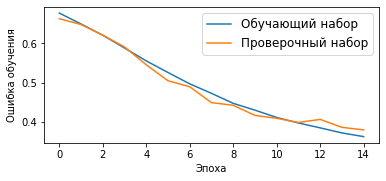

Acc =  0.7627161112503132


Epoch 1: 100%|██████████| 132/132 [00:10<00:00, 12.14it/s]


2023-05-29 17:03:34.986708 Epoch 1, Train loss 0.665, Val loss 0.767, Acc_val = 0.06


Epoch 2: 100%|██████████| 132/132 [00:10<00:00, 12.22it/s]


2023-05-29 17:03:46.068584 Epoch 2, Train loss 0.631, Val loss 0.785, Acc_val = 0.30


Epoch 3: 100%|██████████| 132/132 [00:11<00:00, 11.93it/s]


2023-05-29 17:03:57.439829 Epoch 3, Train loss 0.606, Val loss 0.804, Acc_val = 0.25


Epoch 4: 100%|██████████| 132/132 [00:10<00:00, 12.16it/s]


2023-05-29 17:04:08.611152 Epoch 4, Train loss 0.583, Val loss 0.785, Acc_val = 0.35


Epoch 5: 100%|██████████| 132/132 [00:10<00:00, 12.21it/s]


2023-05-29 17:04:19.722767 Epoch 5, Train loss 0.559, Val loss 0.758, Acc_val = 0.43


Epoch 6: 100%|██████████| 132/132 [00:10<00:00, 12.28it/s]


2023-05-29 17:04:30.758940 Epoch 6, Train loss 0.538, Val loss 0.764, Acc_val = 0.38


Epoch 7: 100%|██████████| 132/132 [00:11<00:00, 11.69it/s]


2023-05-29 17:04:42.379431 Epoch 7, Train loss 0.519, Val loss 0.752, Acc_val = 0.38


Epoch 8: 100%|██████████| 132/132 [00:11<00:00, 11.80it/s]


2023-05-29 17:04:53.872010 Epoch 8, Train loss 0.503, Val loss 0.769, Acc_val = 0.38


Epoch 9: 100%|██████████| 132/132 [00:11<00:00, 11.81it/s]


2023-05-29 17:05:05.351693 Epoch 9, Train loss 0.485, Val loss 0.755, Acc_val = 0.38


Epoch 10: 100%|██████████| 132/132 [00:11<00:00, 11.52it/s]


2023-05-29 17:05:17.122839 Epoch 10, Train loss 0.466, Val loss 0.742, Acc_val = 0.37


Epoch 11: 100%|██████████| 132/132 [00:11<00:00, 11.87it/s]


2023-05-29 17:05:28.556563 Epoch 11, Train loss 0.452, Val loss 0.771, Acc_val = 0.38


Epoch 12: 100%|██████████| 132/132 [00:10<00:00, 12.66it/s]


2023-05-29 17:05:39.272118 Epoch 12, Train loss 0.438, Val loss 0.743, Acc_val = 0.36


Epoch 13: 100%|██████████| 132/132 [00:10<00:00, 12.81it/s]


2023-05-29 17:05:49.854939 Epoch 13, Train loss 0.426, Val loss 0.859, Acc_val = 0.38


Epoch 14: 100%|██████████| 132/132 [00:10<00:00, 12.33it/s]


2023-05-29 17:06:00.840429 Epoch 14, Train loss 0.411, Val loss 0.785, Acc_val = 0.31


Epoch 15: 100%|██████████| 132/132 [00:11<00:00, 11.67it/s]


2023-05-29 17:06:12.461881 Epoch 15, Train loss 0.394, Val loss 0.785, Acc_val = 0.30


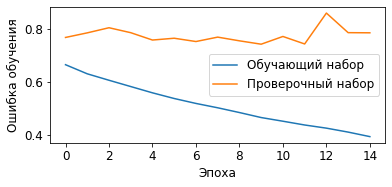

Acc =  0.9125502245332073


Epoch 1: 100%|██████████| 127/127 [00:11<00:00, 11.46it/s]


2023-05-29 17:06:29.216175 Epoch 1, Train loss 0.657, Val loss 0.721, Acc_val = 0.40


Epoch 2: 100%|██████████| 127/127 [00:10<00:00, 11.75it/s]


2023-05-29 17:06:40.426312 Epoch 2, Train loss 0.621, Val loss 0.721, Acc_val = 0.70


Epoch 3: 100%|██████████| 127/127 [00:10<00:00, 11.61it/s]


2023-05-29 17:06:51.759798 Epoch 3, Train loss 0.590, Val loss 0.707, Acc_val = 0.55


Epoch 4: 100%|██████████| 127/127 [00:10<00:00, 11.91it/s]


2023-05-29 17:07:02.830563 Epoch 4, Train loss 0.555, Val loss 0.683, Acc_val = 0.55


Epoch 5: 100%|██████████| 127/127 [00:10<00:00, 11.90it/s]


2023-05-29 17:07:13.895093 Epoch 5, Train loss 0.522, Val loss 0.651, Acc_val = 0.76


Epoch 6: 100%|██████████| 127/127 [00:11<00:00, 11.16it/s]


2023-05-29 17:07:25.697296 Epoch 6, Train loss 0.492, Val loss 0.610, Acc_val = 0.73


Epoch 7: 100%|██████████| 127/127 [00:11<00:00, 11.00it/s]


2023-05-29 17:07:37.677189 Epoch 7, Train loss 0.463, Val loss 0.576, Acc_val = 0.80


Epoch 8: 100%|██████████| 127/127 [00:11<00:00, 11.17it/s]


2023-05-29 17:07:49.452783 Epoch 8, Train loss 0.440, Val loss 0.557, Acc_val = 0.80


Epoch 9: 100%|██████████| 127/127 [00:11<00:00, 11.27it/s]


2023-05-29 17:08:01.143612 Epoch 9, Train loss 0.422, Val loss 0.537, Acc_val = 0.81


Epoch 10: 100%|██████████| 127/127 [00:11<00:00, 11.22it/s]


2023-05-29 17:08:12.884364 Epoch 10, Train loss 0.406, Val loss 0.516, Acc_val = 0.82


Epoch 11: 100%|██████████| 127/127 [00:11<00:00, 10.94it/s]


2023-05-29 17:08:24.922252 Epoch 11, Train loss 0.392, Val loss 0.497, Acc_val = 0.82


Epoch 12: 100%|██████████| 127/127 [00:12<00:00, 10.28it/s]


2023-05-29 17:08:37.729607 Epoch 12, Train loss 0.382, Val loss 0.486, Acc_val = 0.82


Epoch 13: 100%|██████████| 127/127 [00:11<00:00, 10.83it/s]


2023-05-29 17:08:49.893939 Epoch 13, Train loss 0.371, Val loss 0.482, Acc_val = 0.82


Epoch 14: 100%|██████████| 127/127 [00:11<00:00, 11.09it/s]


2023-05-29 17:09:01.767791 Epoch 14, Train loss 0.363, Val loss 0.463, Acc_val = 0.82


Epoch 15: 100%|██████████| 127/127 [00:10<00:00, 11.78it/s]


2023-05-29 17:09:12.955023 Epoch 15, Train loss 0.356, Val loss 0.452, Acc_val = 0.83


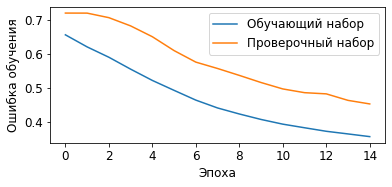

Acc =  0.5543278084714549


Epoch 1: 100%|██████████| 137/137 [00:11<00:00, 11.53it/s]


2023-05-29 17:09:30.643259 Epoch 1, Train loss 0.673, Val loss 0.653, Acc_val = 0.86


Epoch 2: 100%|██████████| 137/137 [00:12<00:00, 11.35it/s]


2023-05-29 17:09:43.045443 Epoch 2, Train loss 0.644, Val loss 0.611, Acc_val = 1.00


Epoch 3: 100%|██████████| 137/137 [00:11<00:00, 11.64it/s]


2023-05-29 17:09:55.159436 Epoch 3, Train loss 0.611, Val loss 0.565, Acc_val = 1.00


Epoch 4: 100%|██████████| 137/137 [00:11<00:00, 11.96it/s]


2023-05-29 17:10:06.952067 Epoch 4, Train loss 0.580, Val loss 0.519, Acc_val = 1.00


Epoch 5: 100%|██████████| 137/137 [00:11<00:00, 11.69it/s]


2023-05-29 17:10:19.012074 Epoch 5, Train loss 0.545, Val loss 0.472, Acc_val = 0.95


Epoch 6: 100%|██████████| 137/137 [00:12<00:00, 11.31it/s]


2023-05-29 17:10:31.497615 Epoch 6, Train loss 0.513, Val loss 0.434, Acc_val = 0.80


Epoch 7: 100%|██████████| 137/137 [00:13<00:00, 10.52it/s]


2023-05-29 17:10:44.891095 Epoch 7, Train loss 0.482, Val loss 0.390, Acc_val = 0.80


Epoch 8: 100%|██████████| 137/137 [00:12<00:00, 11.06it/s]


2023-05-29 17:10:57.605091 Epoch 8, Train loss 0.456, Val loss 0.350, Acc_val = 0.82


Epoch 9: 100%|██████████| 137/137 [00:11<00:00, 11.87it/s]


2023-05-29 17:11:09.489212 Epoch 9, Train loss 0.435, Val loss 0.310, Acc_val = 0.90


Epoch 10: 100%|██████████| 137/137 [00:12<00:00, 10.75it/s]


2023-05-29 17:11:22.605006 Epoch 10, Train loss 0.413, Val loss 0.295, Acc_val = 0.87


Epoch 11: 100%|██████████| 137/137 [00:12<00:00, 10.94it/s]


2023-05-29 17:11:35.494193 Epoch 11, Train loss 0.391, Val loss 0.277, Acc_val = 0.88


Epoch 12: 100%|██████████| 137/137 [00:12<00:00, 10.58it/s]


2023-05-29 17:11:48.828137 Epoch 12, Train loss 0.376, Val loss 0.258, Acc_val = 0.91


Epoch 13: 100%|██████████| 137/137 [00:12<00:00, 10.57it/s]


2023-05-29 17:12:02.151459 Epoch 13, Train loss 0.360, Val loss 0.258, Acc_val = 0.87


Epoch 14: 100%|██████████| 137/137 [00:12<00:00, 10.69it/s]


2023-05-29 17:12:15.343542 Epoch 14, Train loss 0.346, Val loss 0.243, Acc_val = 0.90


Epoch 15: 100%|██████████| 137/137 [00:12<00:00, 10.54it/s]


2023-05-29 17:12:28.707627 Epoch 15, Train loss 0.333, Val loss 0.253, Acc_val = 0.84


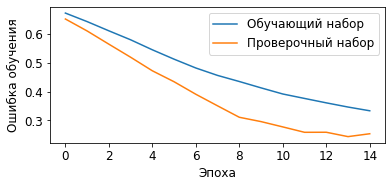

Acc =  0.6549097065462754


Epoch 1: 100%|██████████| 125/125 [00:11<00:00, 10.55it/s]


2023-05-29 17:12:46.082849 Epoch 1, Train loss 0.675, Val loss 0.621, Acc_val = 0.92


Epoch 2: 100%|██████████| 125/125 [00:11<00:00, 10.55it/s]


2023-05-29 17:12:58.528467 Epoch 2, Train loss 0.652, Val loss 0.594, Acc_val = 0.97


Epoch 3: 100%|██████████| 125/125 [00:11<00:00, 10.66it/s]


2023-05-29 17:13:10.856999 Epoch 3, Train loss 0.629, Val loss 0.576, Acc_val = 0.86


Epoch 4: 100%|██████████| 125/125 [00:11<00:00, 10.99it/s]


2023-05-29 17:13:22.808951 Epoch 4, Train loss 0.609, Val loss 0.553, Acc_val = 0.87


Epoch 5: 100%|██████████| 125/125 [00:12<00:00, 10.24it/s]


2023-05-29 17:13:35.663633 Epoch 5, Train loss 0.586, Val loss 0.537, Acc_val = 0.86


Epoch 6: 100%|██████████| 125/125 [00:15<00:00,  8.23it/s]


2023-05-29 17:13:51.408576 Epoch 6, Train loss 0.562, Val loss 0.513, Acc_val = 0.87


Epoch 7: 100%|██████████| 125/125 [00:11<00:00, 11.22it/s]


2023-05-29 17:14:03.111094 Epoch 7, Train loss 0.536, Val loss 0.511, Acc_val = 0.86


Epoch 8: 100%|██████████| 125/125 [00:11<00:00, 11.15it/s]


2023-05-29 17:14:14.933242 Epoch 8, Train loss 0.514, Val loss 0.508, Acc_val = 0.86


Epoch 9: 100%|██████████| 125/125 [00:11<00:00, 11.28it/s]


2023-05-29 17:14:26.599810 Epoch 9, Train loss 0.493, Val loss 0.484, Acc_val = 0.86


Epoch 10: 100%|██████████| 125/125 [00:11<00:00, 10.62it/s]


2023-05-29 17:14:38.971918 Epoch 10, Train loss 0.476, Val loss 0.476, Acc_val = 0.86


Epoch 11: 100%|██████████| 125/125 [00:11<00:00, 10.86it/s]


2023-05-29 17:14:51.094425 Epoch 11, Train loss 0.458, Val loss 0.469, Acc_val = 0.89


Epoch 12: 100%|██████████| 125/125 [00:11<00:00, 10.65it/s]


2023-05-29 17:15:03.517323 Epoch 12, Train loss 0.442, Val loss 0.482, Acc_val = 0.74


Epoch 13: 100%|██████████| 125/125 [00:11<00:00, 10.56it/s]


2023-05-29 17:15:15.948148 Epoch 13, Train loss 0.428, Val loss 0.458, Acc_val = 0.86


Epoch 14: 100%|██████████| 125/125 [00:11<00:00, 10.76it/s]


2023-05-29 17:15:28.163536 Epoch 14, Train loss 0.414, Val loss 0.485, Acc_val = 0.68


Epoch 15: 100%|██████████| 125/125 [00:11<00:00, 10.58it/s]


2023-05-29 17:15:40.639837 Epoch 15, Train loss 0.404, Val loss 0.451, Acc_val = 0.81


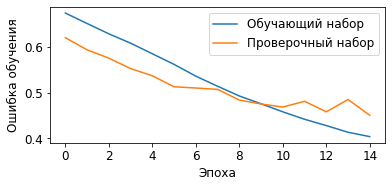

Acc =  0.7470238095238095
Final results
15 epochs. Acc_sk = 0.71 (Sens = 0.82 / Spec = 0.59) 0.76 / 0.91 / 0.55 / 0.65 / 0.75


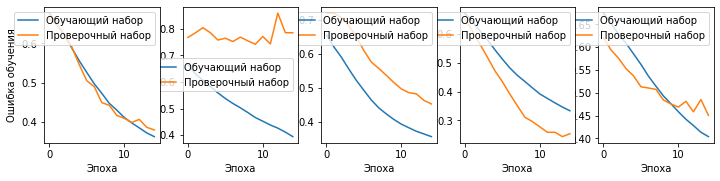

In [50]:
# dir_HC = '../wav'+ os.sep + 'HC' + os.sep
# dir_ALS = '../wav' + os.sep + 'ALS' + os.sep

DataSet_ALS = ALSDataset(dir_HC, dir_ALS)
model = ALS_CNN1()

# Start parameters
# layer1_filt = 64
# lf_num, mf_num, hf_num = 32,16,16    # low-frequency / medium-frequency / high-frequency       
# lf_width,  mf_width,  hf_width  = 12,8,4      # low/medium/high-frequency time span
# lf_height, mf_height, hf_height = 16,8,8      # low/medium/high-frequency frequency span
# lf_h_stride, mf_h_stride, hf_h_stride = 4,2,1
# lf_w_stride, mf_w_stride, hf_w_stride = lf_width//2, mf_width//2, hf_width//2
# optimizer = optim.Adam(model.parameters(),lr=1e-2, weight_decay=1e-1) # 30 epochs. Acc_sk = 0.56 (Sens = 0.47 / Spec = 0.65) 0.66 / 0.37 / 0.64 / 0.62 / 0.55
# optimizer = optim.SGD(model.parameters(),lr=1e-2, weight_decay=1e-1) # 15 epochs. Acc_sk = 0.71 (Sens = 0.75 / Spec = 0.66) 0.65 / 0.82 / 0.72 / 0.78 / 0.61
# lf_height = 24
# optimizer = optim.SGD(model.parameters(),lr=1e-2, weight_decay=1e-1) # 15 epochs. Acc_sk = 0.63 (Sens = 0.75 / Spec = 0.51) 0.72 / 0.71 / 0.59 / 0.63 / 0.57
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.2) # 15 epochs. Acc_sk = 0.61 (Sens = 0.73 / Spec = 0.49) 0.62 / 0.68 / 0.57 / 0.64 / 0.57
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.2) # 15 epochs. Acc_sk = 0.75 (Sens = 0.78 / Spec = 0.71) 0.68 / 0.85 / 0.66 / 0.68 / 0.87 (good behaviour)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.2) # 30 epochs. Acc_sk = 0.76 (Sens = 0.79 / Spec = 0.72) 0.71 / 0.82 / 0.73 / 0.67 / 0.86
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.76 (Sens = 0.78 / Spec = 0.73) 0.73 / 0.88 / 0.67 / 0.65 / 0.87
# mf_height = 12 (old val 8)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.77 (Sens = 0.81 / Spec = 0.73) 0.80 / 0.88 / 0.70 / 0.65 / 0.84
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.6) # 15 epochs. Acc_sk = 0.74 (Sens = 0.78 / Spec = 0.69) 0.77 / 0.86 / 0.71 / 0.64 / 0.73
# hf_height = 12 (old val 8) 
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.73 (Sens = 0.75 / Spec = 0.70) 0.67 / 0.89 / 0.65 / 0.66 / 0.810
# hf_height = 8 (return), mf_height = 16 (old val 12)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.76 (Sens = 0.81 / Spec = 0.71) 0.83 / 0.92 / 0.58 / 0.65 / 0.90
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 100 epochs. Acc_sk = 0.65 (Sens = 0.64 / Spec = 0.66) 0.62 / 0.73 / 0.58 / 0.72 / 0.66
# lf_width = 24 (old value 12)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.76 (Sens = 0.82 / Spec = 0.70) 0.84 / 0.93 / 0.60 / 0.64 / 0.85
# mf_width = 16 (old value 8)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.76 (Sens = 0.80 / Spec = 0.70) 0.77 / 0.89 / 0.59 / 0.67 / 0.91
# hf_height = 16 (old value 8)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.76 (Sens = 0.79 / Spec = 0.73) 0.68 / 0.89 / 0.58 / 0.75 / 0.94
# mf_height = 15 (old value 16)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.76 (Sens = 0.80 / Spec = 0.70) 0.70 / 0.86 / 0.57 / 0.75 / 0.94
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 30 epochs. Acc_sk = 0.71 (Sens = 0.75 / Spec = 0.67) 0.64 / 0.84 / 0.55 / 0.75 / 0.85
# lf_width = 48 (24 old value)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.73 (Sens = 0.77 / Spec = 0.69) 0.68 / 0.84 / 0.55 / 0.74 / 0.89
# lf_width = 32 (24 old value)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.74 (Sens = 0.79 / Spec = 0.69) 0.69 / 0.87 / 0.54 / 0.75 / 0.90
# lf_width = 32 (24 old value)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.74 (Sens = 0.79 / Spec = 0.69) 0.69 / 0.87 / 0.54 / 0.75 / 0.90
# lf_width = 24 (return) + hf_height = 8 (return)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.74 (Sens = 0.80 / Spec = 0.68) 0.76 / 0.87 / 0.54 / 0.69 / 0.87
# mf_height = 12 (before 16)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.78 (Sens = 0.82 / Spec = 0.74) 0.80 / 0.85 / 0.68 / 0.65 / 0.89
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.5) # 15 epochs. Acc_sk = 0.74 (Sens = 0.80 / Spec = 0.68) 0.79 / 0.86 / 0.64 / 0.65 / 0.76
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.3) # 15 epochs. Acc_sk = 0.71 (Sens = 0.73 / Spec = 0.68) 0.69 / 0.67 / 0.64 / 0.67 / 0.85
# hf_height = 12 (old value 8)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.74 (Sens = 0.76 / Spec = 0.72) 0.65 / 0.86 / 0.65 / 0.68 / 0.88
# hf_height = 8 (return)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.77 (Sens = 0.81 / Spec = 0.72) 0.76 / 0.86 / 0.68 / 0.65 / 0.88
# hf_height = 10 (8 before)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.76 (Sens = 0.79 / Spec = 0.72) 0.75 / 0.85 / 0.64 / 0.66 / 0.87
# hf_height = 8 (return) + hf_width = 8 (before 4)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.74 (Sens = 0.81 / Spec = 0.66) 0.79 / 0.86 / 0.64 / 0.63 / 0.76
# return to model with 78% Acc
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.75 (Sens = 0.80 / Spec = 0.70) 0.75 / 0.83 / 0.66 / 0.65 / 0.83
# xavier_uniform changed to kaiming_normal_
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.74 (Sens = 0.78 / Spec = 0.69) 0.63 / 0.88 / 0.53 / 0.75 / 0.94 (good behaviour)
# kaiming_normal_ changed to kaiming_uniform_
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.70 (Sens = 0.75 / Spec = 0.65) 0.62 / 0.87 / 0.53 / 0.77 / 0.79
# kaiming_uniform_ 
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.2) # 15 epochs. Acc_sk = 0.74 (Sens = 0.80 / Spec = 0.69) 0.65 / 0.88 / 0.53 / 0.75 / 0.95
# optimizer = optim.SGD(model.parameters(),lr=5e-4, weight_decay=1e-1, momentum=0.2) # 15 epochs. Acc_sk = 0.74 (Sens = 0.80 / Spec = 0.68) 0.69 / 0.80 / 0.54 / 0.75 / 0.93
# hf_width = 5 (before 4)
# optimizer = optim.SGD(model.parameters(),lr=5e-4, weight_decay=1e-1, momentum=0.2) # 15 epochs. Acc_sk = 0.74 (Sens = 0.78 / Spec = 0.69) 0.65 / 0.84 / 0.58 / 0.74 / 0.90
# xavier_uniform (return) + nn.init.xavier_uniform_(self.fc)
# optimizer = optim.SGD(model.parameters(),lr=5e-4, weight_decay=1e-1, momentum=0.2) # 15 epochs. Acc_sk = 0.67 (Sens = 0.67 / Spec = 0.66) 0.60 / 0.65 / 0.62 / 0.64 / 0.82 (slow curves)
# optimizer = optim.SGD(model.parameters(),lr=2e-3, weight_decay=1e-1, momentum=0.2) # 15 epochs. Acc_sk = 0.71 (Sens = 0.73 / Spec = 0.69) 0.75 / 0.83 / 0.58 / 0.66 / 0.79 
# optimizer = optim.SGD(model.parameters(),lr=2e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.69 (Sens = 0.72 / Spec = 0.67) 0.74 / 0.79 / 0.60 / 0.66 / 0.73
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.73 (Sens = 0.75 / Spec = 0.71) 0.72 / 0.88 / 0.60 / 0.66 / 0.84
# lf_width = 27 (before 24)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.76 (Sens = 0.78 / Spec = 0.73) 0.77 / 0.86 / 0.67 / 0.65 / 0.83
# lf_height = 27 (before 24)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.75 (Sens = 0.80 / Spec = 0.70) 0.79 / 0.90 / 0.73 / 0.65 / 0.74
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.75 (Sens = 0.79 / Spec = 0.70) 0.78 / 0.90 / 0.73 / 0.65 / 0.74
# lf_height = 27 (before 24)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4)
# mf_height = 15 (before 12)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.75 (Sens = 0.80 / Spec = 0.70) 0.79 / 0.90 / 0.71 / 0.65 / 0.75
# mf_width, mf_height = 13,13
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.74 (Sens = 0.81 / Spec = 0.66) 0.81 / 0.94 / 0.65 / 0.65 / 0.74
# mf_width, mf_height = 15,15 (return)
# optimizer = optim.Adam(model.parameters(),lr=1e-4, weight_decay=1e-1) # 15 epochs. Acc_sk = 0.62 (Sens = 0.60 / Spec = 0.65) 0.50 / 0.74 / 0.59 / 0.72 / 0.63
# hf_width,hf_height = 5,5
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.71 (Sens = 0.82 / Spec = 0.59) 0.76 / 0.91 / 0.55 / 0.65 / 0.75
# conv_hf2 added (15x15)
optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4)

k_fold_CV(dataset=DataSet_ALS, model = model, optimizer=optimizer, train = training_loop, n_epochs=15)

In [60]:
# Test 1
test_img = torch.rand(64,86)
test_img_row = test_img.view(-1,64*86)
print(test_img.shape)
print(test_img_row.shape)

# Test 2
test_img = torch.rand(1,10)
test_img_row = test_img.squeeze()
print(test_img.shape)
print(test_img_row.shape)

#Test 3
# print(torch.sigmoid(torch.tensor(-1)), torch.sigmoid(torch.tensor(0)), torch.sigmoid(torch.tensor(1)))

#Test 4
# x = torch.randn(3)
# x3 = torch.cat((x, x, x), 0)
# print(x3)

#Test 5
A = np.random.random((2,3))
print(A.shape)
A = A.reshape((1,A.shape[0],A.shape[1]))
print(A.shape)

torch.Size([64, 86])
torch.Size([1, 5504])
torch.Size([1, 10])
torch.Size([10])
(2, 3)
(1, 2, 3)


### CV-Fold selection

In [2]:
file_name =  'HC_ALS_table.xlsx' # path to file + file name

xls_file = pd.ExcelFile(file_name)
# print(xls_file.sheet_names)

# https://stackoverflow.com/questions/17071871/how-do-i-select-rows-from-a-dataframe-based-on-column-values

df_HC = xls_file.parse('Control')
df_ALS = xls_file.parse('ALS')
# print(df_HC['fold']==1)
for fold_num in range(1,6):
    HC_fold = df_HC.loc[df_HC['fold']==fold_num]
    ALS_fold = df_ALS.loc[df_ALS['fold']==fold_num]
    # print(HC_fold)
    # print(ALS_fold)
    print(np.hstack((HC_fold['Subject code'].to_numpy(), ALS_fold['Subject code'].to_numpy())))
    HC_age = (float)(HC_fold.loc[:, 'Age'].mean())
    HC_m = (HC_fold.loc[HC_fold['Sex']=='m'])
    HC_f = (HC_fold.loc[HC_fold['Sex']=='f'])
    ALS_age = (float)(ALS_fold.loc[:, 'Age'].mean())
    ALS_m = (ALS_fold.loc[ALS_fold['Sex']=='m'])
    ALS_f = (ALS_fold.loc[ALS_fold['Sex']=='f'])
    print(f'Fold {fold_num} HC age mean = {HC_age:.2f}, mens = {len(HC_m.index)}, womens = {len(HC_f.index)}')
    print(f'Fold {fold_num} ALS age mean = {ALS_age:.2f}, mens = {len(ALS_m.index)}, womens = {len(ALS_f.index)}')

[ 26  97 117  85  53  86 127  92 102  27  32  72  39]
Fold 1 HC age mean = 52.43, mens = 3, womens = 4
Fold 1 ALS age mean = 56.83, mens = 3, womens = 3
[ 28 123  63  99  81 125 129  68  21  55  48  78  42]
Fold 2 HC age mean = 53.71, mens = 3, womens = 4
Fold 2 ALS age mean = 58.33, mens = 4, womens = 2
[ 61  16 115 109 111   2 107  46  84  64  52  24  76]
Fold 3 HC age mean = 55.43, mens = 2, womens = 5
Fold 3 ALS age mean = 59.67, mens = 4, womens = 2
[ 77   6  65  24 131 119  25  94  62  28   8  98  22]
Fold 4 HC age mean = 53.00, mens = 3, womens = 3
Fold 4 ALS age mean = 60.86, mens = 5, womens = 2
[ 49  89   4  42 113 121  96  20  58  80  31 100]
Fold 5 HC age mean = 54.17, mens = 2, womens = 4
Fold 5 ALS age mean = 61.00, mens = 4, womens = 2
